# PIK3CA: Effects of Mutation on IRS1

<b> Standard imports for playing with and plotting data frames. </b>

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.stats.multitest

<b> Import CPTAC data </b>

In [2]:
import CPTAC

Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter CPTAC.embargo() to open the webpage for more details.


In [3]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

# PI3KCA mutation and IRS1 proteome abundance (with control)

### Perform a t-test with mutated and non-mutated protein levels

In [4]:
protList = ['IRS1']
pcutoff = 0.05 / len(protList)
gene = 'PIK3CA'

sigResults = [];
for protein in protList: 
    if protein in proteomics.columns:
        cross = CPTAC.compare_mutations(proteomics, protein, gene)
        cross = cross[["Mutation", protein]].dropna(axis=0)
        mutated = cross.loc[cross["Mutation"] == "Missense_Mutation"]
        wt = cross.loc[cross["Mutation"] == "Wildtype"]
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        if(ttest[1] <= pcutoff):
            sigResults.append(protein)
            print("Test for " + protein + ": ")
            print(ttest) 

Test for IRS1: 
Ttest_indResult(statistic=-3.5379526832870027, pvalue=0.00055342765400399)


 ### We can now plot the data 

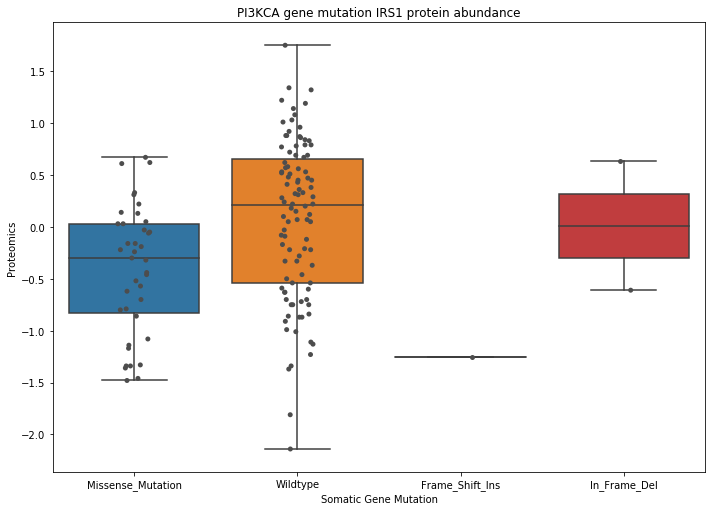

In [5]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
somatic_boxplot = sns.boxplot(data=cross, x="Mutation",y='IRS1', ax = ax)
somatic_boxplot.set_title("PI3KCA gene mutation IRS1 protein abundance")
somatic_boxplot = sns.stripplot(data=cross, x="Mutation", y='IRS1',jitter=True, color=".3")
somatic_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Proteomics")
plt.show()

# PI3KCA mutation and IRS1 proteome abundance (no control)

<b> Take out the control </b>

In [6]:
proteomics = proteomics[:100]

### Perform a t-test with mutated and non-mutated protein levels

In [7]:
protList = ['IRS1']
pcutoff = 0.05 / len(protList)
gene = 'PIK3CA'

sigResults = [];
for protein in protList: 
    if protein in proteomics.columns:
        cross = CPTAC.compare_mutations(proteomics, protein, gene)
        cross = cross[["Mutation", protein]].dropna(axis=0)
        mutated = cross.loc[cross["Mutation"] == "Missense_Mutation"]
        wt = cross.loc[cross["Mutation"] == "Wildtype"]
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        if(ttest[1] <= pcutoff):
            sigResults.append(protein)
            print("Test for " + protein + ": ")
            print(ttest) 
        else:
            print("Unsignificant result for " + protein + ": ")
            print(ttest) 
            

Unsignificant result for IRS1: 
Ttest_indResult(statistic=-0.5010103010709803, pvalue=0.6175227666432365)


 ### We can now plot the data 

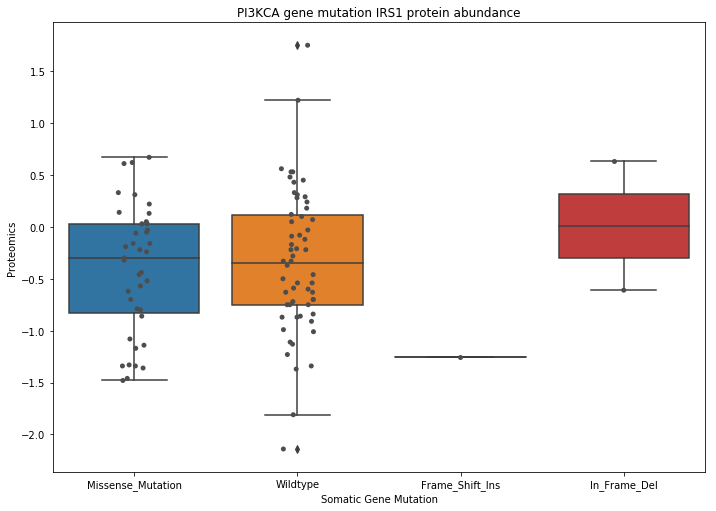

In [8]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
somatic_boxplot = sns.boxplot(data=cross, x="Mutation",y='IRS1', ax = ax)
somatic_boxplot.set_title("PI3KCA gene mutation IRS1 protein abundance")
somatic_boxplot = sns.stripplot(data=cross, x="Mutation", y='IRS1',jitter=True, color=".3")
somatic_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Proteomics")
plt.show()

# PI3KCA mutation and IRS1 phosphoproteome abundance 

In [13]:
sites = phos.columns
p_values = []
site_names = []

phosProtList = ['IRS1']

for protein in phosProtList:
    pattern = re.compile(protein)
    isInList = filter(pattern.search, sites)
    if next(isInList, None) is not None:
        phosphositesdf = CPTAC.compare_mutations(phos, protein, gene)
        phosphositesdf = phosphositesdf.loc[phosphositesdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
        for site in phosphositesdf.columns:
            if (site is not 'Mutation'):
                sitedf = CPTAC.compare_mutations(phos, site, gene)
                mutateddf = sitedf.loc[sitedf['Mutation'] != 'Wildtype'].dropna(axis=0)
                wtdf = sitedf.loc[sitedf['Mutation'] == 'Wildtype'].dropna(axis=0)
                ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
                p_values.append(ttest[1])
                site_names.append(site)     
                
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values)[0]
pvalues = statsmodels.stats.multitest.fdrcorrection(p_values)[1]
significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

significant_vals = dict(zip(significant_sites, significant_pvalues))

print(significant_sites)
print(significant_pvalues)
print(significant_vals)

['ABI1-T200' 'ABI2-S183' 'ABI2-S233' ... 'ZYX-S281' 'ZZEF1-S2444'
 'ZZEF1-T1477']
[0.01303875 0.04630198 0.03352245 ... 0.00631643 0.01200212 0.0474412 ]
{'ABI1-T200': 0.01303874589327742, 'ABI2-S183': 0.046301976857730714, 'ABI2-S233': 0.0335224460137841, 'ABI2-S368': 0.0011425936753669769, 'ABI3BP-S1419': 0.0025357457982802855, 'ABLIM1-S367': 0.009425473092480274, 'ABLIM1-S452': 0.04208372601748848, 'ABLIM1-S586': 0.011051903505308408, 'ABLIM1-S587': 0.026789796898257348, 'ABLIM2-S279': 0.017137116360263653, 'ABLIM3-S277': 0.02466809745441628, 'ABLIM3-S372': 0.022182953759635183, 'ABLIM3-S388': 0.02006938571713198, 'ABLIM3-S503': 0.014258806426384515, 'ABLIM3-S504': 0.03579693171659557, 'ACIN1-S208': 0.004270214969707459, 'ACIN1-S210': 0.00601829560613053, 'ACIN1-S295': 0.001477940622656576, 'ACIN1-T682': 0.03464011169528901, 'ANKIB1-S737': 0.027584095194836497, 'API5-S464': 0.020206948385886405, 'ARHGDIA-Y133': 0.0008228121590525419, 'ARID1A-S610': 0.018014342273572886, 'ARID2-S1300

In [10]:
phosdf = CPTAC.compare_mutations(phos, protein, gene)

phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor']

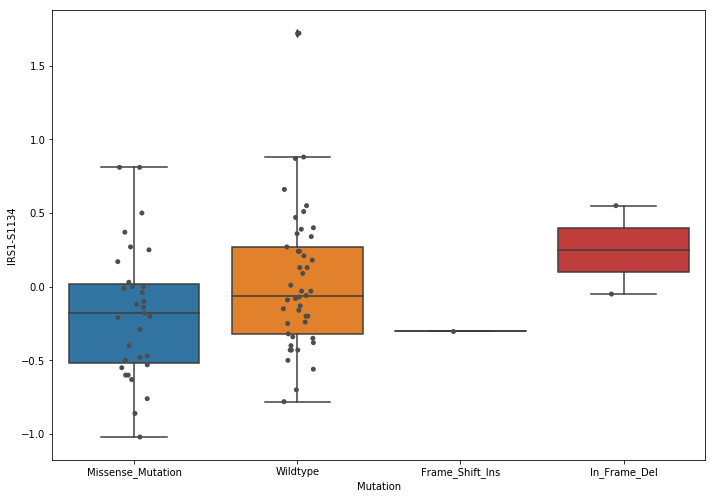

In [11]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

boxplt = sns.boxplot(data = phosdf, x = 'Mutation', y = 'IRS1-S1134')
boxplt = sns.stripplot(data = phosdf, x = 'Mutation', y = 'IRS1-S1134', jitter = True, color = '.3')
plt.show()

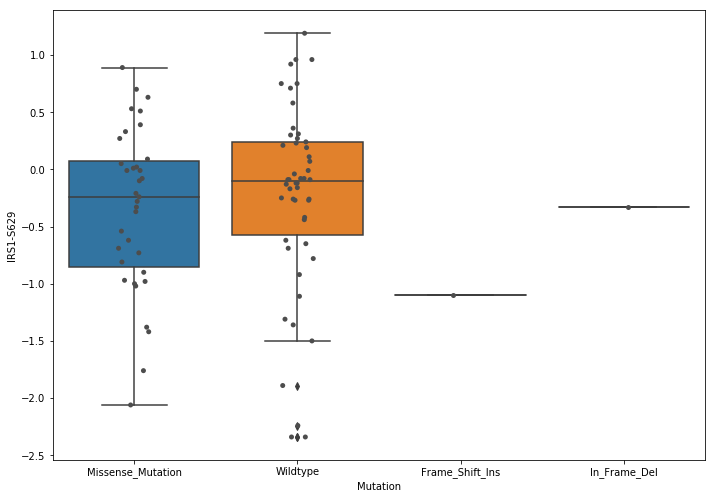

In [14]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

boxplt = sns.boxplot(data = phosdf, x = 'Mutation', y = 'IRS1-S629')
boxplt = sns.stripplot(data = phosdf, x = 'Mutation', y = 'IRS1-S629', jitter = True, color = '.3')
plt.show()

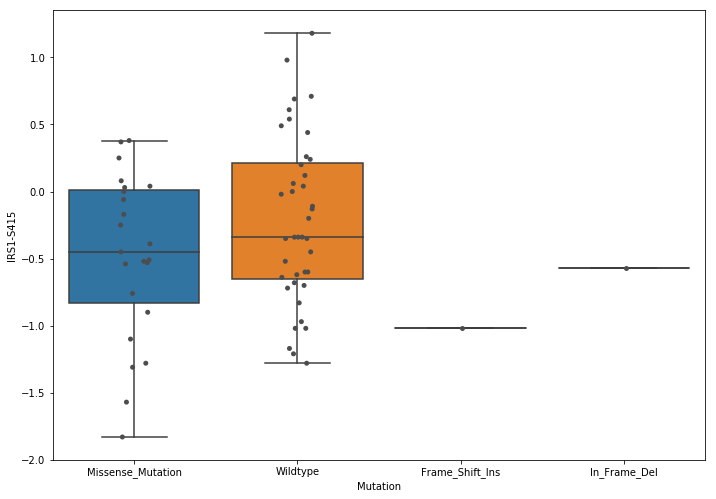

In [16]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

boxplt = sns.boxplot(data = phosdf, x = 'Mutation', y = 'IRS1-S415')
boxplt = sns.stripplot(data = phosdf, x = 'Mutation', y = 'IRS1-S415', jitter = True, color = '.3')
plt.show()